<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/followers/subscribers_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# input file with list of followers
INPUT_FILE = 'lutheran_followers_test10.csv'
# INPUT_FILE = 'lutheran_followers.csv'
# INPUT_FILE = 'baptist_followers.csv'

OUTPUT_FILE = INPUT_FILE.replace('.csv', '_posts.csv') # e.g. "lutheran_followers_posts.csv"

In [2]:
!pip install vk_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00


Сделать функцию скрывающую реальный id пользователя id->новый id

In [3]:
import vk_api
from vk_api.exceptions import ApiError
from config import TOKEN, VERSION
ACCESS_TOKEN = TOKEN

In [4]:
def get_only_original_posts(user_id, access_token, max_posts=1000):
    """
    Получает только посты, опубликованные самим пользователем (без репостов)

    :param user_id: ID пользователя (например, 123456789)
    :param access_token: токен VK API
    :param max_posts: ограничение на количество постов (по умолчанию 1000)
    :return: список оригинальных постов или None в случае ошибки
    """
    try:
        vk_session = vk_api.VkApi(token=access_token)
        vk = vk_session.get_api()

        original_posts = []
        offset = 0
        count = 100

        while len(original_posts) < max_posts:
            response = vk.wall.get(
                owner_id=user_id,
                count=count,
                offset=offset
            )

            posts = response.get('items', [])
            if not posts:
                break

            for post in posts:
                if 'copy_history' not in post:
                    original_posts.append(post)
                    if len(original_posts) >= max_posts:
                        break

            offset += count
            time.sleep(0.4)

        return original_posts

    except ApiError as e:
        print(f"Ошибка VK API: {e}")
        return None

In [5]:
import vk_api
from vk_api.exceptions import ApiError
import time

def get_all_user_posts(user_id, access_token, max_posts=10000):
    """
    Получает ВСЕ посты пользователя (с пагинацией)

    :param user_id: ID пользователя (например, 123456789)
    :param access_token: токен VK API
    :param max_posts: ограничение на максимальное количество постов (по умолчанию 1000)
    :return: список всех постов или None в случае ошибки
    """
    try:
        vk_session = vk_api.VkApi(token=access_token)
        vk = vk_session.get_api()

        all_posts = []
        offset = 0
        count = 100

        while True:
            response = vk.wall.get(
                owner_id=user_id,
                count=count,
                offset=offset
            )

            posts = response['items']
            if not posts:
                break

            all_posts.extend(posts)
            offset += count

            if len(all_posts) >= max_posts:
                break

            time.sleep(0.4)

        return all_posts

    except ApiError as e:
        print(f"Ошибка VK API: {e}")
        return None

In [6]:
# USER_ID = 103249

# all_posts = get_all_user_posts(USER_ID, ACCESS_TOKEN)

# if all_posts:
#     print(f"Всего постов: {len(all_posts)}")
#     for i, post in enumerate(all_posts[:10], 1):
#         print(f"\nПост #{i}:")
#         print(f"Дата: {post['date']}")
#         if 'text' in post:
#             print(f"Текст: {post['text']}")
# else:
#     print("Не удалось получить посты. Возможно, профиль закрыт или токен неверный.")

In [7]:
import vk_api
from vk_api.exceptions import ApiError
import time
import csv
from datetime import datetime

def get_original_posts_with_text(user_id, access_token, max_posts=1000):
    """
    Получает оригинальные посты пользователя (без репостов) и с текстом
    :param user_id: ID пользователя (например, 123456789)
    :param access_token: токен VK API
    :param max_posts: максимальное количество постов (по умолчанию 1000)
    :return: список постов или None в случае ошибки
    """
    try:
        vk_session = vk_api.VkApi(token=access_token)
        vk = vk_session.get_api()

        posts = []
        offset = 0
        count = 100

        while len(posts) < max_posts:
            response = vk.wall.get(
                owner_id=user_id,
                count=count,
                offset=offset
            )

            items = response.get('items', [])
            if not items:
                break

            for post in items:
                if 'copy_history' not in post and post.get('text'):
                    posts.append(post)
                    if len(posts) >= max_posts:
                        break

            offset += count
            time.sleep(0.4)

        return posts

    except ApiError as e:
        print(f"Ошибка VK API: {e}")
        return None

def save_to_csv(posts, filename="vk_posts.csv"):
    """
    Сохраняет посты в CSV-файл
    :param posts: список постов
    :param filename: имя файла для сохранения
    """
    if not posts:
        print("Нет постов для сохранения.")
        return

    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["Дата", "Текст", "Ссылка"])

        for post in posts:
            post_date = datetime.fromtimestamp(post['date']).strftime('%Y-%m-%d %H:%M:%S')
            post_text = post['text'].replace('\n', ' ').strip()
            post_url = f"https://vk.com/wall{post['owner_id']}_{post['id']}"

            writer.writerow([post_date, post_text, post_url])

    print(f"Данные сохранены в {filename}")

In [8]:
# posts = get_original_posts_with_text(USER_ID, ACCESS_TOKEN)

# if posts:
#     print(f"Найдено {len(posts)} постов.")
#     save_to_csv(posts)
# else:
#     print("Не удалось получить посты.")

In [9]:
#Дописать фильтрация из csv can_acces_close and is_closed

import vk_api
from vk_api.exceptions import ApiError
import time
import csv
from datetime import datetime
import pandas as pd

def get_original_posts_with_text(user_id, access_token, max_posts=1000):
    """Получает оригинальные посты пользователя с текстом"""
    try:
        vk_session = vk_api.VkApi(token=access_token)
        vk = vk_session.get_api()

        posts = []
        offset = 0
        count = 100

        while len(posts) < max_posts:
            try:
                response = vk.wall.get(
                    owner_id=user_id,
                    count=count,
                    offset=offset
                )

                items = response.get('items', [])
                if not items:
                    break

                for post in items:
                    if 'copy_history' not in post and post.get('text'):
                        posts.append({
                            'user_id': user_id, # удалить
                            'date': post['date'],
                            'text': post['text'],
                            'post_id': post['id']
                        })
                        if len(posts) >= max_posts:
                            break

                offset += count
                time.sleep(0.4)

            except ApiError as e:
                print(f"Ошибка для пользователя {user_id}: {e}")
                break

        return posts

    except Exception as e:
        print(f"Критическая ошибка для пользователя {user_id}: {e}")
        return []

def process_all_users(input_csv, output_csv, access_token, max_posts_per_user=100):
    """Обрабатывает всех пользователей из CSV"""
    try:
        followers = pd.read_csv(input_csv)
        user_ids = followers['id'].tolist()

        all_posts = []

        for user_id in user_ids:
            posts = get_original_posts_with_text(user_id, access_token, max_posts_per_user)
            all_posts.extend(posts)
            time.sleep(0.1)

        if all_posts:
            df = pd.DataFrame(all_posts)
            df['date'] = pd.to_datetime(df['date'], unit='s')
            df['url'] = df.apply(lambda x: f"https://vk.com/wall{x['user_id']}_{x['post_id']}", axis=1)
            df.to_csv(output_csv, index=False, encoding='utf-8', sep=';')
            print(f"Сохранено {len(df)} постов в {output_csv}")
        else:
            print("Не найдено ни одного поста")

    except Exception as e:
        print(f"Ошибка при обработке файла: {e}")

In [10]:
import hashlib

def hide_user_id(real_id):
    hashed_id = hashlib.sha256(str(real_id).encode()).hexdigest()
    return hashed_id[:10]


real_id = 103249
new_id = hide_user_id(real_id)
print(f"Реальный ID: {real_id}, Новый ID: {new_id}")

Реальный ID: 103249, Новый ID: 2e16af048c


In [11]:
input_path = f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/religion/{INPUT_FILE}'
print(f"input_path={input_path}")
process_all_users(input_path, OUTPUT_FILE, ACCESS_TOKEN)

input_path=https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/religion/lutheran_followers_test10.csv
Ошибка для пользователя 340807: [15] Access denied: user hid his wall from accessing from outside
Ошибка для пользователя 435927: [15] Access denied: user hid his wall from accessing from outside
Ошибка для пользователя 929126: [15] Access denied: user hid his wall from accessing from outside
Ошибка для пользователя 2042325: [15] Access denied: user hid his wall from accessing from outside
Ошибка для пользователя 2048472: [15] Access denied: user hid his wall from accessing from outside
Ошибка для пользователя 2272321: [15] Access denied: user hid his wall from accessing from outside
Сохранено 400 постов в lutheran_followers_test10_posts.csv


In [12]:
import vk_api
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import seaborn as sns
from tqdm import tqdm

def analyze_activity(posts):
    """Анализ активности по временным периодам"""
    df = pd.DataFrame(posts)
    if df.empty:
        return None

    # Группировка по временным периодам
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['year_month'] = df['date'].dt.to_period('M')
    df['weekday'] = df['date'].dt.weekday
    df['hour'] = df['date'].dt.hour

    # Анализ по годам
    yearly = df.groupby('year').size().reset_index(name='count')

    # Анализ по месяцам
    monthly = df.groupby('year_month').size().reset_index(name='count')
    monthly['year_month'] = monthly['year_month'].astype(str)

    # Анализ по дням недели
    weekdays = df.groupby('weekday').size().reset_index(name='count')
    weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
    weekdays['weekday_name'] = weekdays['weekday'].apply(lambda x: weekday_names[x])

    # Анализ по часам
    hourly = df.groupby('hour').size().reset_index(name='count')

    return {
        'yearly': yearly,
        'monthly': monthly,
        'weekdays': weekdays,
        'hourly': hourly,
        'total_posts': len(df)
    }

def visualize_activity(analysis, filename):
    """Визуализация результатов анализа"""
    plt.figure(figsize=(15, 10))

    # График по годам
    plt.subplot(2, 2, 1)
    sns.barplot(x='year', y='count', data=analysis['yearly'])
    plt.title('Активность по годам')

    # График по месяцам
    plt.subplot(2, 2, 2)
    sns.lineplot(x='year_month', y='count', data=analysis['monthly'])
    plt.title('Активность по месяцам')
    plt.xticks(rotation=45)

    # График по дням недели
    plt.subplot(2, 2, 3)
    sns.barplot(x='weekday_name', y='count', data=analysis['weekdays'], order=weekday_names)
    plt.title('Активность по дням недели')

    # График по часам
    plt.subplot(2, 2, 4)
    sns.barplot(x='hour', y='count', data=analysis['hourly'])
    plt.title('Активность по часам дня')

    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

NameError: name 'analysis' is not defined

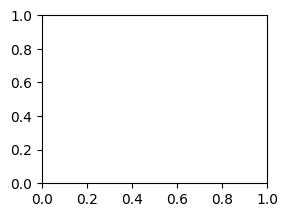

In [13]:
plt.subplot(2, 2, 1)
sns.barplot(x='year', y='count', data=analysis['yearly'])
plt.title('Активность по годам')

In [ ]:
plt.subplot(2, 2, 2)
sns.lineplot(x='year_month', y='count', data=analysis['monthly'])
plt.title('Активность по месяцам')
plt.xticks(rotation=45)

In [ ]:
plt.subplot(2, 2, 3)
sns.barplot(x='weekday_name', y='count', data=analysis['weekdays'], order=weekday_names)
plt.title('Активность по дням недели')

In [ ]:
plt.subplot(2, 2, 4)
sns.barplot(x='hour', y='count', data=analysis['hourly'])
plt.title('Активность по часам дня')

In [ ]:
import vk_api
from vk_api.exceptions import ApiError
import time
import pandas as pd

def filter_active_users_from_csv(df):
    """Фильтрует активных пользователей на основе данных из CSV"""
    df_filtered = df.copy()

    # Фильтруем пользователей по критериям:
    # 1. Нет значения в deactivated (не удаленные/заблокированные)
    # 2. Страница либо открыта, либо мы можем получить доступ к закрытой
    df_filtered = df_filtered[
        (df_filtered['deactivated'].isna()) &
        ((df_filtered['is_closed'] == False) | (df_filtered['can_access_closed'] == True))
    ]

    return df_filtered['id'].tolist()

def get_original_posts_with_text(user_id, access_token, max_posts=1000):
    """Получает оригинальные посты пользователя с текстом"""
    try:
        vk_session = vk_api.VkApi(token=access_token)
        vk = vk_session.get_api()

        posts = []
        offset = 0
        count = 100

        while len(posts) < max_posts:
            try:
                response = vk.wall.get(
                    owner_id=user_id,
                    count=count,
                    offset=offset
                )

                items = response.get('items', [])
                if not items:
                    break

                for post in items:
                    if 'copy_history' not in post and post.get('text'):
                        posts.append({
                            'user_id': user_id,
                            'date': post['date'],
                            'text': post['text'],
                            'post_id': post['id']
                        })
                        if len(posts) >= max_posts:
                            break

                offset += count
                time.sleep(0.4)

            except ApiError as e:
                print(f"Ошибка для пользователя {user_id}: {e}")
                break

        return posts

    except Exception as e:
        print(f"Критическая ошибка для пользователя {user_id}: {e}")
        return []

def process_all_users(input_csv, output_csv, access_token, max_posts_per_user=100):
    """Обрабатывает всех пользователей из CSV"""
    try:
        followers = pd.read_csv(input_csv)
        print(f"Всего пользователей в исходном файле: {len(followers)}")

        active_user_ids = filter_active_users_from_csv(followers)
        print(f"Найдено активных пользователей: {len(active_user_ids)}")

        if not active_user_ids:
            print("Нет активных пользователей для обработки")
            return

        all_posts = []

        for user_id in active_user_ids:
            posts = get_original_posts_with_text(user_id, access_token, max_posts_per_user)
            all_posts.extend(posts)
            time.sleep(0.1)

        if all_posts:
            df_posts = pd.DataFrame(all_posts)
            df_posts['date'] = pd.to_datetime(df_posts['date'], unit='s')
            df_posts['url'] = df_posts.apply(lambda x: f"https://vk.com/wall{x['user_id']}_{x['post_id']}", axis=1)

            df_users = pd.read_csv(input_csv)
            df_posts = df_posts.merge(df_users, how='left', left_on='user_id', right_on='id')

            df_posts.to_csv(output_csv, index=False, encoding='utf-8', sep=';')
            print(f"Сохранено {len(df_posts)} постов в {output_csv}")
        else:
            print("Не найдено ни одного поста")

    except Exception as e:
        print(f"Ошибка при обработке файла: {e}")


#ACCESS_TOKEN = "your_access_token_vk"
#INPUT_FILE = "/content/baptist_followers.csv"
#OUTPUT_FILE = "/content/baptists_posts.csv"


process_all_users(INPUT_FILE, OUTPUT_FILE, ACCESS_TOKEN)